In [1]:
#check if gpu is available for loading and training the model. 
import torch

if torch.cuda.is_available() == True:
    print("CUDA available")
else:
    print("CUDA not available")

CUDA available


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
#import scrublet as scr
import scvi
from scvi.model.utils import mde
import seaborn as sns
import torch

/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

model_dir = "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models"

In [5]:
ref_adata = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/Braun_HDBCA_HNOCA-harmonized_2khvg.h5ad')
ref_adata

AnnData object with n_obs × n_vars = 1665937 × 2000
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'batch', 'PoolCleanOrder', 'PoolOrder', 'CellClass_Mossi', '_scvi_batch', '_scvi_labels'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene', 'ensgene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CellClass_Mossi_colors', 'Subregion_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_condition', 'hvg', 'log1p', 'title'
    obsm: 'Factors',

In [6]:
ref_adata.layers['lognorm'] = ref_adata.X.copy()
ref_adata.X = ref_adata.layers['counts'].copy()

In [7]:
ref_adata.varm = dict()
ref_adata.obs["batch"] = ref_adata.obs["donor_id"].astype(str).copy()

#### Add annotation from Mossi-Albiach (https://www.biorxiv.org/content/10.1101/2023.09.01.555882v1)

In [8]:
ref_meta = pd.read_excel("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/table_S2.xlsx")

In [9]:
ref_adata.obs['PoolCleanOrder'] = ref_adata.obs['cluster_id'].astype(str)

In [10]:
mapping_dict = dict(zip(ref_meta['PoolCleanOrder'].astype(str), ref_meta['PoolOrder'].astype(str)))
ref_adata.obs['PoolOrder'] = ref_adata.obs['PoolCleanOrder'].map(mapping_dict).fillna("No mapping")
ref_adata.obs['PoolOrder']

CellID
10X89_1:AAACGGGAGGCTACGA     658
10X89_1:ACGAGGAAGAGCCTAG     658
10X89_1:ACGCCAGTCGATAGAA     662
10X89_1:CCGGGATCAGACACTT     658
10X89_1:CGACTTCTCCCACTTG     669
                            ... 
10X302_7:AGAGAATAGAGGATCC    610
10X302_8:AAGCCATTCCACCTCA    603
10X302_8:ACGGTTAGTTAGGCCC    603
10X302_8:CATGCCTCAACCCGCA    605
10X302_8:CCTTTGGCAACGATTC    603
Name: PoolOrder, Length: 1665937, dtype: object

In [11]:
meta = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/DevPool5_2.h5ad')

/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
meta.obs['CellClass'].value_counts()

CellClass
Neuron           218
Radial glia      145
Neuroblast       104
Neuronal IPC      32
Glioblast         27
Vascular          22
Pre-astrocyte     16
Fibroblast        15
Erythrocyte        8
OPC                7
Neural crest       2
Failed             1
Pre-OPC            1
Name: count, dtype: int64

In [13]:
mapping_dict = dict(zip(meta.obs['PrevCluster'].astype(str), meta.obs['CellClass'].astype(str)))
ref_adata.obs['CellClass_Mossi'] = ref_adata.obs['PoolOrder'].map(mapping_dict).fillna("No mapping")
ref_adata.obs['CellClass_Mossi']

CellID
10X89_1:AAACGGGAGGCTACGA     Erythrocyte
10X89_1:ACGAGGAAGAGCCTAG     Erythrocyte
10X89_1:ACGCCAGTCGATAGAA     Erythrocyte
10X89_1:CCGGGATCAGACACTT     Erythrocyte
10X89_1:CGACTTCTCCCACTTG     Erythrocyte
                                ...     
10X302_7:AGAGAATAGAGGATCC       Vascular
10X302_8:AAGCCATTCCACCTCA       Vascular
10X302_8:ACGGTTAGTTAGGCCC       Vascular
10X302_8:CATGCCTCAACCCGCA       Vascular
10X302_8:CCTTTGGCAACGATTC       Vascular
Name: CellClass_Mossi, Length: 1665937, dtype: object

In [14]:
ref_adata.obs['CellClass_Mossi'].replace('Failed', 'COP', inplace=True)
ref_adata = ref_adata[ref_adata.obs['CellClass_Mossi']!='No mapping'].copy()

In [15]:
ref_adata.obs['CellClass_Mossi'].value_counts()

CellClass_Mossi
Neuron           561754
Radial glia      519908
Neuroblast       285699
Neuronal IPC     110260
Glioblast         94213
Pre-astrocyte     32967
Fibroblast        19161
Vascular          11741
Erythrocyte        8958
OPC                5557
Pre-OPC            5240
Neural crest        871
COP                 633
Name: count, dtype: int64

In [16]:
scvi.model.SCVI.setup_anndata(
    ref_adata,
    batch_key="batch",
    )

In [17]:
# PARAMS
BATCH_SIZE = 1024
EPOCHS_PRETRAIN = 500
EPOCHS_FINETUNE = 100

In [18]:
vae = scvi.model.SCVI(
    ref_adata,  
    n_latent=20,
    n_hidden=256,
    **arches_params,
    )

In [19]:
vae.train(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS_PRETRAIN,
    early_stopping=True,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-813e9040-38b5-0f9d-9d39-1010f827161f/3/0]


Epoch 2/500:   0%|          | 1/500 [00:15<2:09:01, 15.51s/it, v_num=1, train_loss_step=783, train_loss_epoch=834]

Epoch 500/500: 100%|██████████| 500/500 [2:09:56<00:00, 15.54s/it, v_num=1, train_loss_step=771, train_loss_epoch=771]  

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [2:09:56<00:00, 15.59s/it, v_num=1, train_loss_step=771, train_loss_epoch=771]


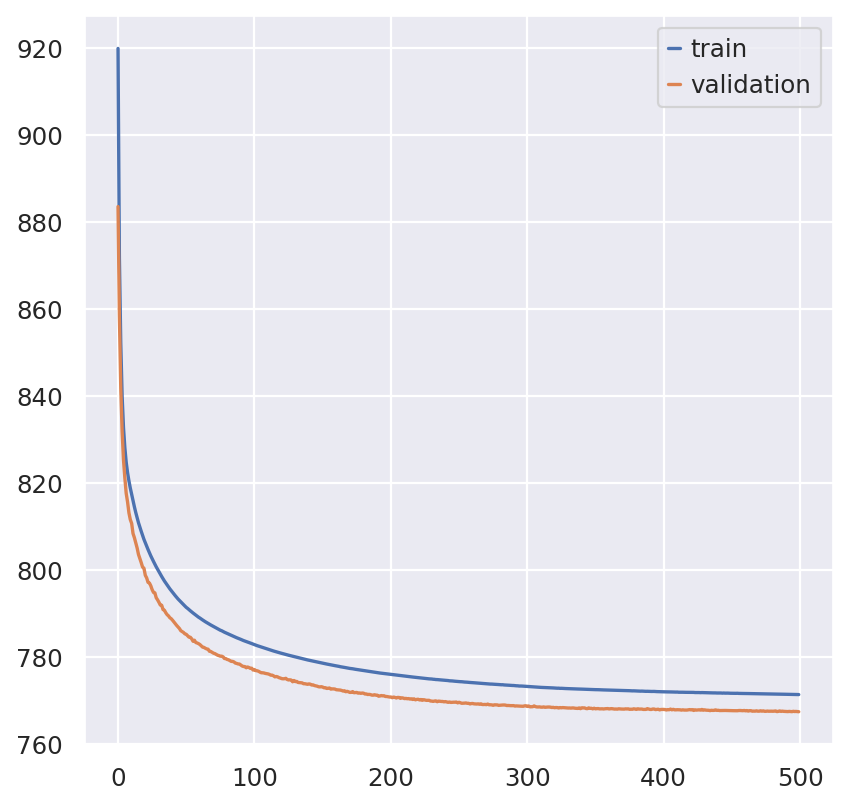

In [20]:
plt.plot(vae.history['elbo_train']['elbo_train'], label='train');
plt.plot(vae.history['elbo_validation']['elbo_validation'], label='validation');
plt.legend()

In [21]:
vae.save(
    os.path.join('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scvi', "model.pt"),
    overwrite=True,
    save_anndata=False,
)

In [22]:
ref_adata.obsm["X_scVI"] = vae.get_latent_representation(give_mean=True)
ref_adata.obsm["X_umap"] = mde(ref_adata.obsm["X_scVI"])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


[<Axes: title={'center': 'Subregion'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'CellClass_Mossi'}, xlabel='UMAP1', ylabel='UMAP2'>]

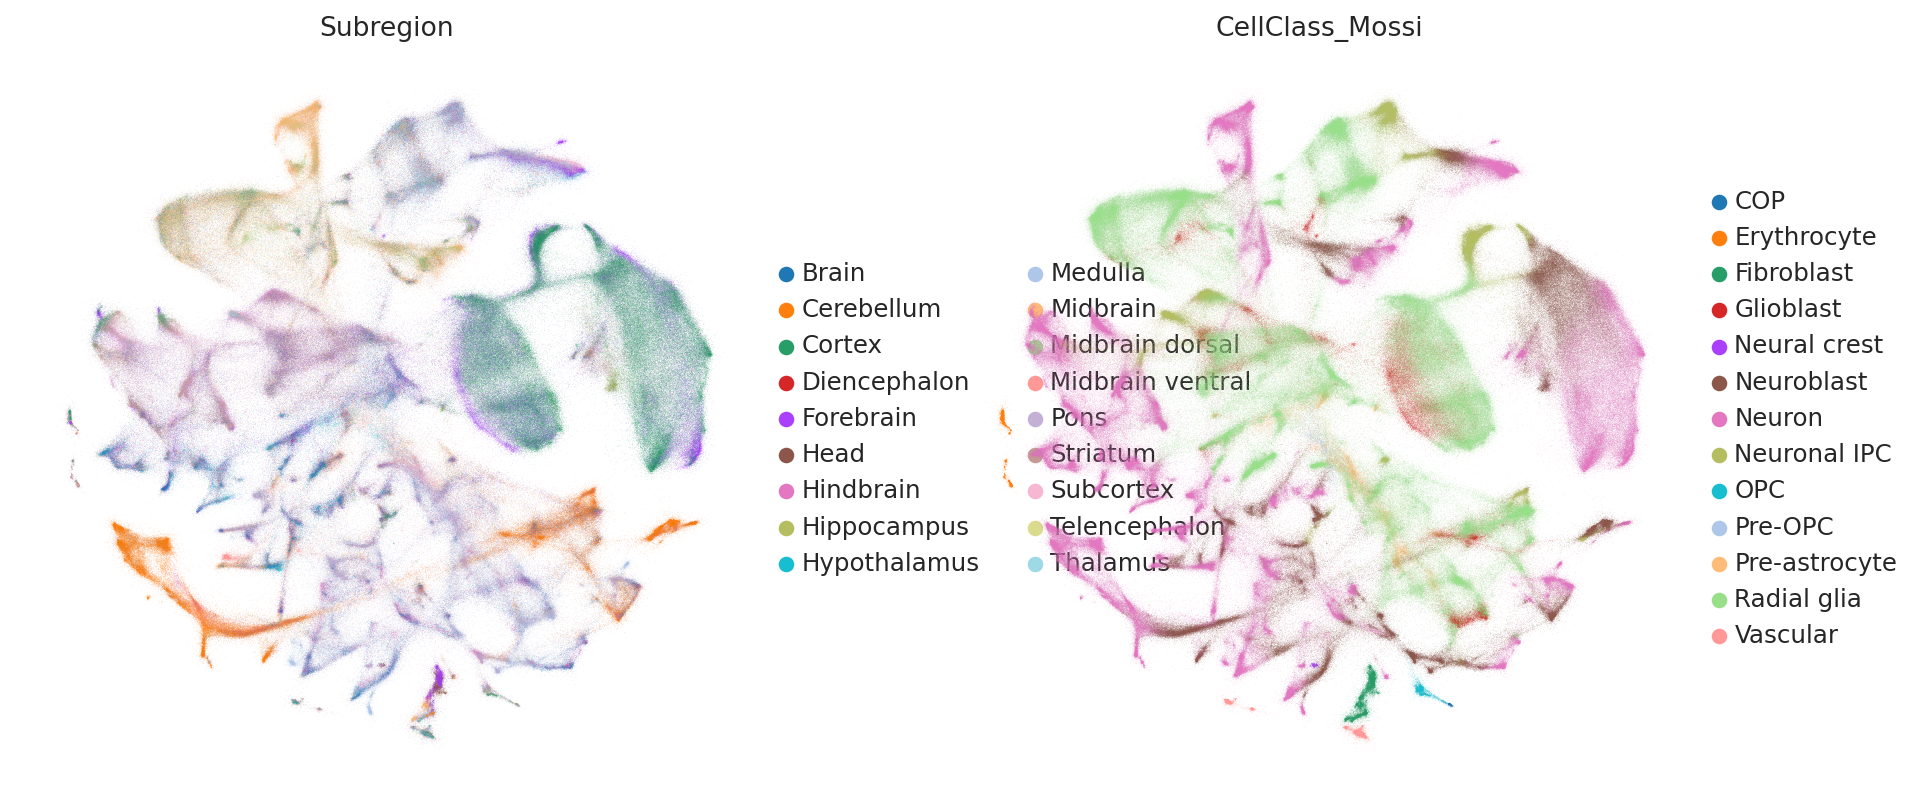

In [23]:
sc.pl.umap(
        ref_adata,
        color=["Subregion","CellClass_Mossi"],
        show=False,
    )

In [24]:
vae = scvi.model.SCVI.load(dir_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scvi/model.pt', adata=ref_adata)

INFO     File                                                                                                      
         /hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scvi/model.pt/
         model.pt already downloaded                                                                               


/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = t

In [25]:
ref_adata.obs['CellClass_Mossi'] = ref_adata.obs['CellClass_Mossi'].astype(str)
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=ref_adata,
    labels_key='CellClass_Mossi',
    unlabeled_category="Unknown",
)

In [26]:
lvae.train(
    batch_size=BATCH_SIZE,
    max_epochs=EPOCHS_FINETUNE,
    n_samples_per_label=100,
    early_stopping=True,
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-813e9040-38b5-0f9d-9d39-1010f827161f/3/0]


Epoch 74/100:  73%|███████▎  | 73/100 [58:16<21:39, 48.14s/it, v_num=1, train_loss_step=738, train_loss_epoch=747]  

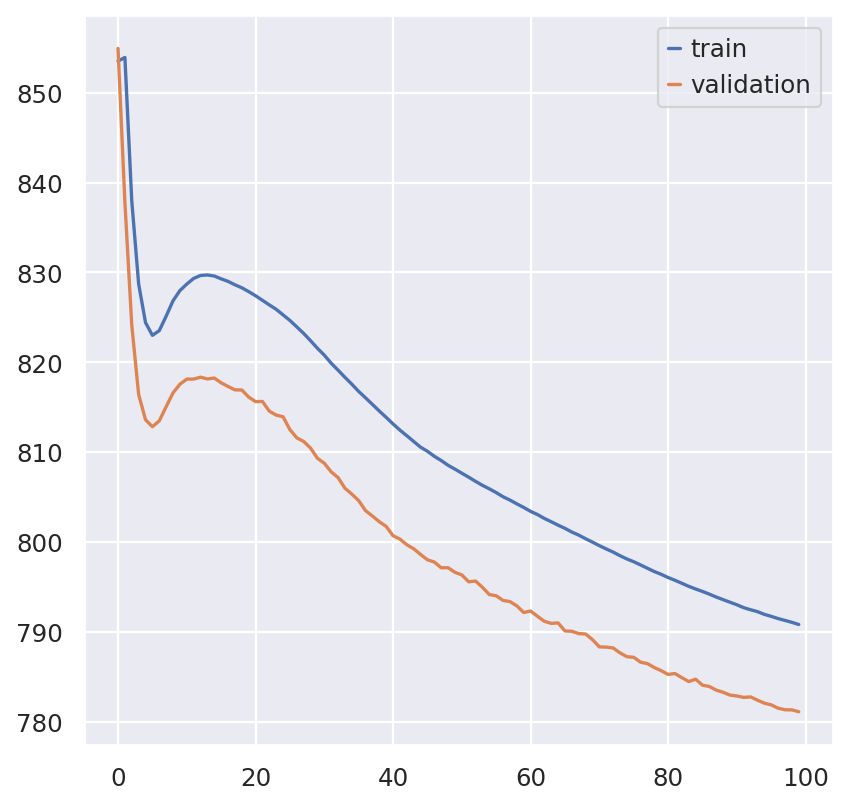

In [ ]:
plt.plot(lvae.history['elbo_train']['elbo_train'], label='train');
plt.plot(lvae.history['elbo_validation']['elbo_validation'], label='validation');
plt.legend()

In [ ]:
lvae.save(
    os.path.join('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/models/scanvi', "model.pt"),
    overwrite=True,
    save_anndata=False,
)

[<Axes: title={'center': 'Subregion'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'CellClass'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>]

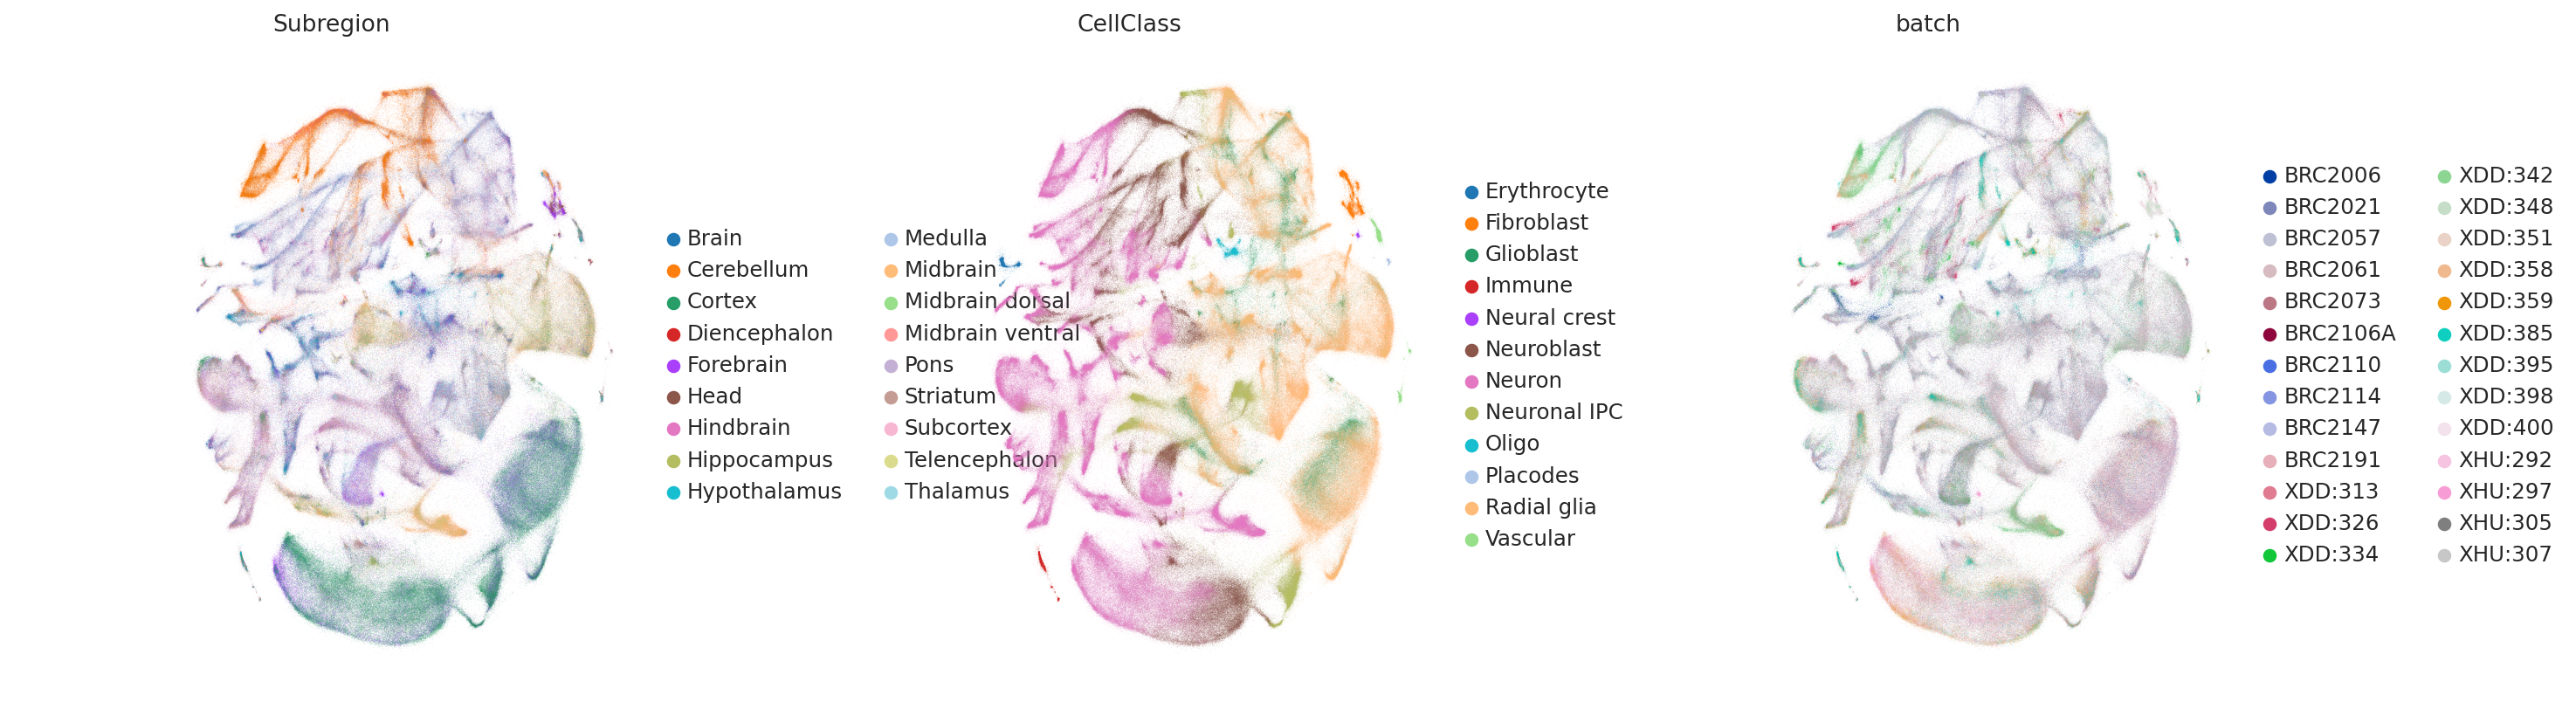

In [ ]:
sc.pl.umap(
        ref_adata,
        color=["Subregion","CellClass","batch"],
        show=False,
    )

In [ ]:
ref_adata.write_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/Braun_HDBCA_HNOCA-harmonized_2khvg.h5ad')

In [ ]:
query_adata

AnnData object with n_obs × n_vars = 55327 × 23409
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca

In [11]:
query_adata.obs["subregion_class"] = "Unknown"

In [12]:
query_adata.varm = dict()
query_adata.obs["batch"] = query_adata.obs["Day"].astype(str).copy()

In [13]:
query_adata.X = query_adata.layers['counts'].copy()

Load SCANVI model

In [14]:
scvi.model.SCANVI.prepare_query_anndata(query_adata, lvae)

INFO     Found 99.65% reference vars in query data.                                                                


/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


### Load query

In [15]:
query_adata

AnnData object with n_obs × n_vars = 55327 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca_

In [16]:
vae_q = scvi.model.SCANVI.load_query_data(query_adata, lvae)

In [17]:
vae_q.train(
    max_epochs=500,
    plan_kwargs=dict(weight_decay=0.0),
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-1cdfd511-7631-f63b-d685-70feaf8f26a0/0/0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



Epoch 500/500: 100%|██████████| 500/500 [1:08:38<00:00,  8.13s/it, loss=1.37e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [1:08:38<00:00,  8.24s/it, loss=1.37e+03, v_num=1]


In [18]:
query_adata.obs["ref"] = "query"
ref_adata.obs["ref"] = "reference"

In [19]:
adata_full = query_adata.concatenate(ref_adata)

/scratch/24875867/ipykernel_3569005/2180432954.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_full = query_adata.concatenate(ref_adata)


In [20]:
adata_full.obs["batch"] = (
    query_adata.obs["batch"].tolist() + ref_adata.obs["batch"].tolist()
)

In [21]:
adata_full.obsm["X_scARCHES"] = vae_q.get_latent_representation(adata_full)
full_latent = pd.DataFrame(adata_full.obsm["X_scARCHES"])
full_latent.index = adata_full.obs.index

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/data/_utils.py:172: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/data/_utils.py:172: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [22]:
full_latent.to_csv("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/assets/map_braun_latent.csv")

In [23]:
adata_full.obsm["X_umap"] = mde(adata_full.obsm["X_scARCHES"])

[<Axes: title={'center': 'CellClass'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'ref'}, xlabel='UMAP1', ylabel='UMAP2'>]

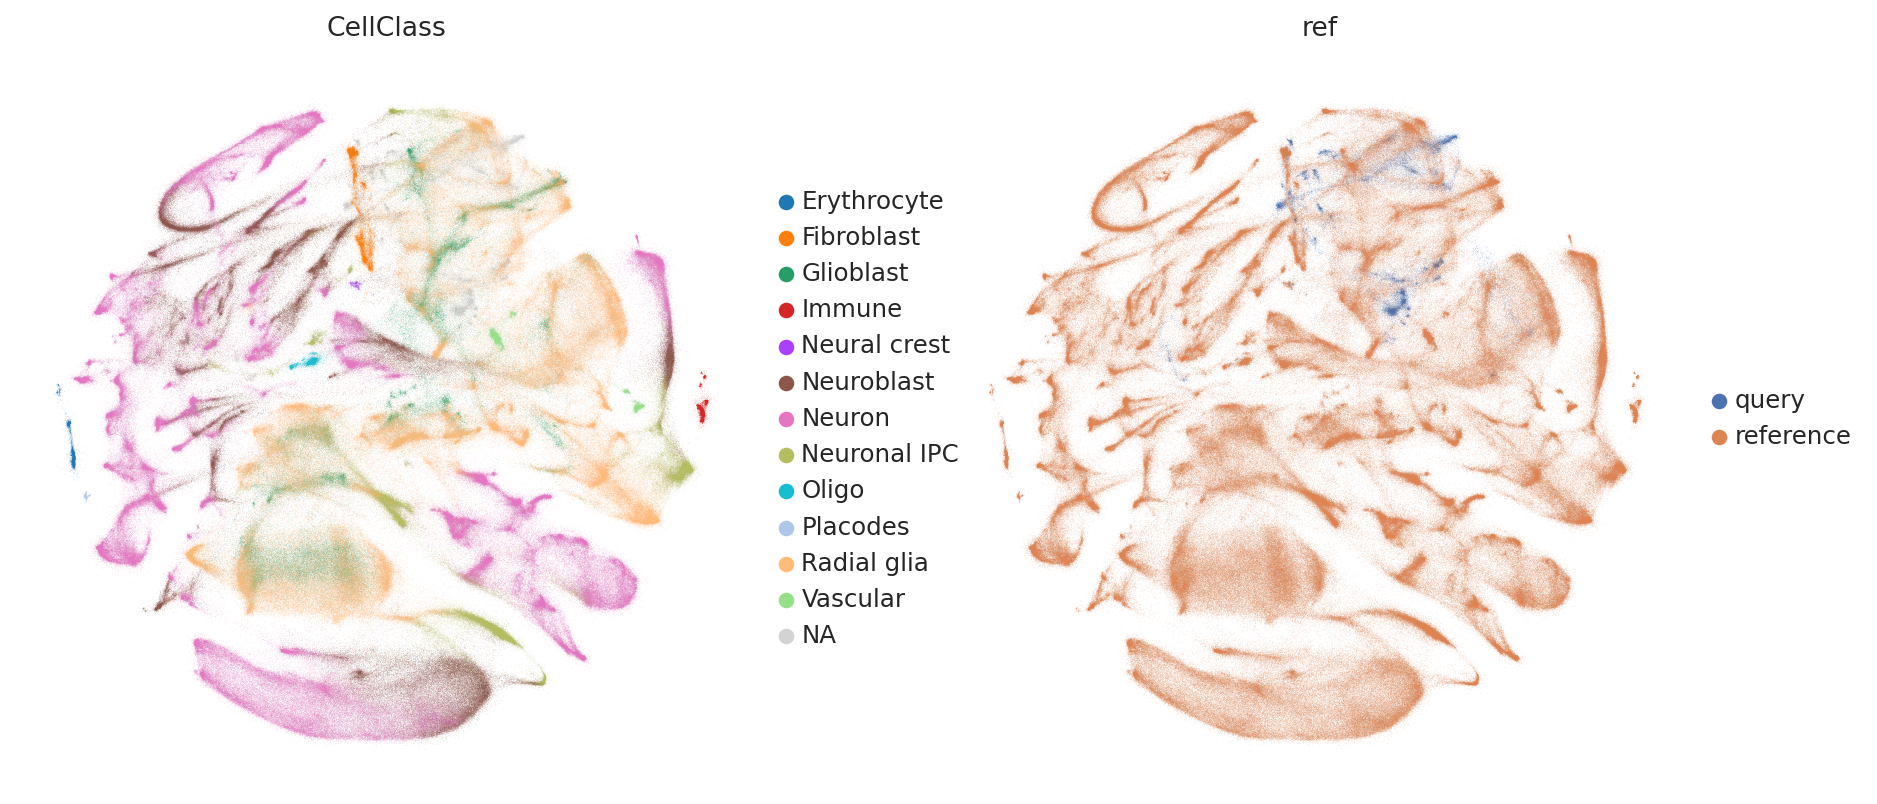

In [24]:
sc.pl.umap(
    adata_full,
    color=["CellClass", "ref"],
    show=False,
)

### Also train the HNOCA on this model, as the presence scores are not provided in the published data

In [10]:
query_adata = sc.read_h5ad('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_pre-release_public_subset.h5ad')

In [11]:
query_adata.obs["subregion_class"] = "Unknown"

In [14]:
query_adata.obs['batch']

homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_53    homosapiens_hindbrain_2020_bdrhapsodywholetran...
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_69    homosapiens_hindbrain_2020_bdrhapsodywholetran...
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_72    homosapiens_hindbrain_2020_bdrhapsodywholetran...
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_76    homosapiens_hindbrain_2020_bdrhapsodywholetran...
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_78    homosapiens_hindbrain_2020_bdrhapsodywholetran...
                                                                                                                                           ...                       

In [15]:
query_adata.varm = dict()
query_adata.obs["batch"] = query_adata.obs["batch"].astype(str).copy()

In [16]:
query_adata.X = query_adata.layers['counts'].copy()

In [17]:
scvi.model.SCANVI.prepare_query_anndata(query_adata, lvae)

INFO     Found 100.0% reference vars in query data.                                                                


In [18]:
vae_q = scvi.model.SCANVI.load_query_data(query_adata, lvae)

/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/data/_utils.py:172: UserWarning: Category 181 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [19]:
vae_q.train(
    max_epochs=500,
    plan_kwargs=dict(weight_decay=0.0),
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-1cdfd511-7631-f63b-d685-70feaf8f26a0/0/0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/500:   0%|          | 1/500 [04:58<41:23:58, 298.67s/it, loss=694, v_num=1]

/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
query_adata.obs["ref"] = "query"
ref_adata.obs["ref"] = "reference"

In [ ]:
adata_full = query_adata.concatenate(ref_adata)

/scratch/24875867/ipykernel_3569005/2180432954.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_full = query_adata.concatenate(ref_adata)


In [ ]:
adata_full.obs["batch"] = (
    query_adata.obs["batch"].tolist() + ref_adata.obs["batch"].tolist()
)

In [ ]:
adata_full.obsm["X_scARCHES"] = vae_q.get_latent_representation(adata_full)
full_latent = pd.DataFrame(adata_full.obsm["X_scARCHES"])
full_latent.index = adata_full.obs.index

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/data/_utils.py:172: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/scvi/data/_utils.py:172: UserWarning: Category 1 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


In [ ]:
full_latent.to_csv("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/assets/hnoca_map_braun_latent.csv")